#### data612 - Group Project 3 : Recommender System (Accuracy and other factors)
# date: 2019-06-30
# by: Sang Yoon (Andy) Hwang, Santosh Cheruku, Anthony Munoz

The purpose of this project is to calculate the accurancy of using different algorithms. The different accurancy terms compared are RMSE (Root Mean Square Error) and MAE (Mean Average Error)

# Data Preparation

We are going to use Book Crossing data set from Jester

https://grouplens.org/datasets/book-crossing/

In [166]:
import pandas as pd
import numpy as np
import surprise
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Dataset
from surprise import KNNBasic
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [167]:
df = pd.read_csv('https://raw.githubusercontent.com/san123i/CUNY/master/Semester2/612-RecommenderSystem/data/ml-100k/ratings.csv')

In [168]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just to make our life a little bit easier, we will change the names of the columns.

In [169]:
df.columns = ['user','item','rating','timestamp']

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
user         100836 non-null int64
item         100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Modelling

We will find the best algorithm based on RMSE. 

In [171]:
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

Let's split data into 5 folds

In [172]:
data.split(n_folds=5)

# SVD

In [173]:
algo = surprise.SVD()
rmse_svd = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8679
------------
Fold 2
RMSE: 0.8691
------------
Fold 3
RMSE: 0.8786
------------
Fold 4
RMSE: 0.8795
------------
Fold 5
RMSE: 0.8701
------------
------------
Mean RMSE: 0.8730
------------
------------


In [174]:
# result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
# result['test_rmse'] 

# Non-negative Matrix Factorization

In [175]:
algo = surprise.NMF()
rmse_nmf = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.9168
------------
Fold 2
RMSE: 0.9130
------------
Fold 3
RMSE: 0.9236
------------
Fold 4
RMSE: 0.9261
------------
Fold 5
RMSE: 0.9175
------------
------------
Mean RMSE: 0.9194
------------
------------


In [176]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

# BaselineOnly

In [177]:
algo = surprise.BaselineOnly()
rmse_bo = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 0.8655
------------
Fold 2
Estimating biases using als...
RMSE: 0.8685
------------
Fold 3
Estimating biases using als...
RMSE: 0.8784
------------
Fold 4
Estimating biases using als...
RMSE: 0.8785
------------
Fold 5
Estimating biases using als...
RMSE: 0.8685
------------
------------
Mean RMSE: 0.8719
------------
------------


In [178]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

Surprisingly, BaselineOnly is the winner! We will now test accuracy using training set on test set.

# BaselineOnly with ALS

We will perform train/test (80/20) split to create model. 

In [179]:
trainset, testset = train_test_split(data, test_size=.20)

We will configure ALS parameter for BaselineOnly

In [180]:
bsl_options = {'method': 'als'}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

# Train the algorithm on the trainset, and predict ratings for the testset
predictions_als = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions_als)

Estimating biases using als...
RMSE: 0.8743


0.8742782252512707

Let's create DataFrame using prediction result.

In [181]:
prediction_df = pd.DataFrame(predictions_als)
prediction_df.head()

,uid,iid,r_ui,est,details
0,448,6645,2.5,3.180808,{u'was_impossible': False}
1,610,82459,4.0,3.901135,{u'was_impossible': False}
2,20,4848,1.5,4.007598,{u'was_impossible': False}
3,387,51662,3.5,3.466974,{u'was_impossible': False}
4,514,4995,4.0,3.742236,{u'was_impossible': False}


Let's select worst/top 10 prediction results on testset.

In [182]:
worst_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=False).head(10)
top_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=True).head(10)

Worst 10 - it was way off.

In [183]:
prediction_df.iloc[worst_10.index]

,uid,iid,r_ui,est,details
7534,573,3996,0.5,4.494127,{u'was_impossible': False}
820,125,4973,0.5,4.474026,{u'was_impossible': False}
17192,256,5618,0.5,4.471325,{u'was_impossible': False}
17215,256,7099,0.5,4.351392,{u'was_impossible': False}
9506,393,5902,0.5,4.177536,{u'was_impossible': False}
10647,413,1198,1.0,4.651508,{u'was_impossible': False}
6203,573,1127,0.5,4.106658,{u'was_impossible': False}
3315,522,106100,0.5,4.103862,{u'was_impossible': False}
10556,129,1358,0.5,4.096177,{u'was_impossible': False}
10846,393,74458,0.5,4.081789,{u'was_impossible': False}


Best 10 - it predicted perfectly.

In [184]:
prediction_df.iloc[top_10.index]

,uid,iid,r_ui,est,details
8818,122,1196,5.0,5.000000,{u'was_impossible': False}
6751,171,318,5.0,5.000000,{u'was_impossible': False}
1534,122,2959,5.0,5.000000,{u'was_impossible': False}
17560,452,1136,5.0,5.000000,{u'was_impossible': False}
6245,80,5388,4.0,3.999995,{u'was_impossible': False}
6088,226,8880,3.5,3.500190,{u'was_impossible': False}
15573,328,8464,3.0,2.999762,{u'was_impossible': False}
6686,314,748,3.0,3.000261,{u'was_impossible': False}
17591,226,413,3.0,3.000308,{u'was_impossible': False}
18604,561,2794,3.0,3.000383,{u'was_impossible': False}


We can also use individual uid and iid to check individual prediciton result. Let's select one of the options in testset.

In [185]:
test_10 = testset[0:10]

In [186]:
# prediction using training set compare the results with testset
uid = test_10[1][0]   # raw user id (as in the ratings file).
iid = test_10[1][1]   # raw item id (as in the ratings file).

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=test_10[1][2], verbose=True)

user: 610        item: 82459      r_ui = 4.00   est = 3.90   {u'was_impossible': False}


We will then recommend top 5 movies by predicted ratings for any selected user. This time, I will merge item title data set with rating data set.

In [187]:
item_names = pd.read_csv('https://raw.githubusercontent.com/san123i/CUNY/master/Semester2/612-RecommenderSystem/data/ml-100k/movies.csv')
item_names = item_names.iloc[:,[0,1]]
item_names.columns = ['iid', 'title']
prediction_df = prediction_df.merge(item_names, on = 'iid', how = 'inner')

In [188]:
def recommender_user(uid):
    top_5 = prediction_df[prediction_df.uid == uid].sort_values(by = 'est', ascending = False).head(5)
    for i in range(len(top_5)):
        print('top 5 movies for uid: {0} are iid: {1} - {2} with predicted ratings of {3}'.format(uid, top_5.iid.values[i], top_5.title.values[i], top_5.est.values[i]))

recommender_user(uid)

top 5 movies for uid: 610 are iid: 904 - Rear Window (1954) with predicted ratings of 4.3830885256
top 5 movies for uid: 610 are iid: 1197 - Princess Bride, The (1987) with predicted ratings of 4.32877397521
top 5 movies for uid: 610 are iid: 1136 - Monty Python and the Holy Grail (1975) with predicted ratings of 4.32326260902
top 5 movies for uid: 610 are iid: 7361 - Eternal Sunshine of the Spotless Mind (2004) with predicted ratings of 4.27288406006
top 5 movies for uid: 610 are iid: 48516 - Departed, The (2006) with predicted ratings of 4.26391447139


# Conclusion - Evaluation

In [189]:
rmse_models = [np.mean(rmse_svd['rmse']),np.mean(rmse_nmf['rmse']),np.mean(rmse_bo['rmse'])]
rmse_df = pd.DataFrame(rmse_models)
rmse_df.index = ['SVD','NMF','BaselineOnly']
rmse_df.columns = ['RMSE - CV 5 folds']

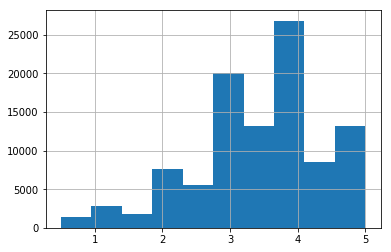

In [190]:
df.rating.hist()

In [191]:
rmse_df

,RMSE - CV 5 folds
SVD,0.873027
NMF,0.919422
BaselineOnly,0.871864


Our first thought was that SVD would give us the best result but it did not as RMSE for SVD is little bit higher than BaselineOnly's. We cannot, however, strictly say that one should always prefer BaselineOnly to SGD based SVD - depending on the case, one can still use SVD if that is more suitable for his/her own purpose. 

We then have to think about why SVD had higher RMSE. 

Our guess is that it could be something to do with feature scaling issue - how ratings are scaled. 
From the documentation of the dataset we used (http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) and from the rating historgram, we know that ratings are half-star incremented. On the other hand, alternative dataset with 1 million ratings, which we could not run SVD due to the memory issue, (http://files.grouplens.org/datasets/movielens/ml-1m-README.txt) contains whole-star ratings only. 

According to benchmark RMSE examples on http://surpriselib.com/, we see that RMSE for SVD using 100k dataset is usually around 0.934 but only 0.873 using 1m dataset.

Since SVD is based on SGD, (https://scikit-learn.org/stable/modules/sgd.html) there are several disdvantages - 1) SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations. 2) SGD is sensitive to feature scaling.

For the future reference, it will be a worth try to compare the RMSE of each model one another in different rating scales to see if there will be any improvement.